# Building a Neural Network from Scratch to Learn Images

In this project, I created a neural network from scratch using NumPy. This neural net takes input features from an image and learns the image - for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

We compare input feature mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.

Source: https://bmild.github.io/fourfeat/ 


This project is inspired by and built off of the authors' demo. 

### Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np

# imports /content/assignment2/models/neural_net.py if you mounted correctly 
from neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  

## Helper Functions

### Experiment Runner

The `NN_experiment` function initializes the neural network defined in `neural_net.py` with the desired parameters (like layer size, number of layers, learning rate, optimizer, etc), and then trains and tests the net with the `X_train`,`y_train`, `X_test` and `y_test` datasets. The function outputs the net, the PSNR over time, the MSE over time, and the predicted image at each epoch, so we can see how the neural net learns our input image.

In [2]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt):
  
    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers, learning_rate, opt)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))

    # For each epoch...
    for epoch in tqdm(range(epochs)):

        # Shuffle the dataset
        # TODO implement this
        random_idx = list(range(len(X_train)))
        np.random.shuffle(random_idx)
        X_train = X_train[random_idx,]
        y_train = y_train[random_idx,]
        
        # Training
        # Run the forward pass of the model to get a prediction and record the psnr
        # TODO implement this
        # Run the backward pass of the model to compute the loss, record the loss, and update the weights
        # TODO implement this
        out = net.forward(X_train)
        l = net.backward(y_train)
        
        train_loss[epoch] = l
        train_psnr[epoch] = psnr(y_train, out)
        
        # Testing
        # No need to run the backward pass here, just run the forward pass to compute and record the psnr
        # TODO implement this
        out = net.forward(X_test)
        test_psnr[epoch] = psnr(y_test, out)
        predicted_images[epoch] = out
        
        net.update()
        

    return net, train_psnr, test_psnr, train_loss, predicted_images

### Image Data and Feature Mappings

The `get_image` function loads our image that we want to learn (by default, we use the image of the lion that the authors of the original paper used) and crop a square out from the center.

In [3]:
# Data loader
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Download image, take a square crop from the center  
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Create input pixel coordinates in the unit square
  coords = np.linspace(0, 1, img.shape[0], endpoint=False)
  x_test = np.stack(np.meshgrid(coords, coords), -1)
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

In [14]:
output_size = 3
size = 32

The `get_B_dict` and `input_mapping` functions are used to compare the different mappings (none, basic, and gaussian Fourier). For the guassian Fourier, we generate 256 pairs of numbers generated from a Guassian distribution with mean 0 and std 1, 10, or 100. We then use these frequencies to generate our Fourier mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$. 

In [5]:
# Create the mappings dictionary of matrix B
def get_B_dict():
    B_dict = {}
    B_dict['none'] = None

    # add B matrix for basic, gauss_1.0, gauss_10.0, gauss_100.0
    B_dict['basic'] = np.identity(2)
    B_dict['gauss_1'] = np.random.normal(0,1,(256,2))
    B_dict['gauss_10'] = np.random.normal(0,10,(256,2))
    B_dict['gauss_100'] = np.random.normal(0,100,(256,2))

    return B_dict

In [6]:
# Given tensor x of input coordinates, map it using B
# taken from https://bmild.github.io/fourfeat/
def input_mapping(x, B):
    if B is None:
        # "none" mapping - just returns the original input coordinates
        return x
    else:
        # "basic" mapping and "gauss_X" mappings project input features using B
        x = (2 * np.pi * x) @ B.T # this is taken from the referenced paper above (https://bmild.github.io/fourfeat/)
        return np.concatenate([np.sin(x), np.cos(x)], axis=-1)

The `get_input_features` function maps the image data to our mapping, by reshaping it and then using the `input_mapping` function to get the input features.

In [7]:
# Apply the input feature mapping to the train and test data
def get_input_features(B_dict, mapping):
  # mapping is the key to the B_dict, which has the value of B
  # B is then used with the function `input_mapping` to map x  
  y_train = train_data[1].reshape(-1, output_size)
  y_test = test_data[1].reshape(-1, output_size)
  X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
  X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
  return X_train, y_train, X_test, y_test

### MSE Loss and PSNR Error (Fill in TODOs)

These functions are just used to measure our error (MSE) and the signal to noise ratio (PSNR) of the images, so we can see quantitatively how our neural net performs over time.

In [8]:
def mse(y, p):
    # consistent with implementation in neural_net.py
    return 1/2 * np.mean((y-p)**2)

def psnr(y, p):
    error = mse(y,p)
    return 10 * np.log10(1/(error*2))

### Plotting

Some helper functions to plot.

In [9]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
  # plot the training loss
  plt.subplot(2, 1, 1)
  plt.plot(train_loss)
  plt.title('MSE history')
  plt.xlabel('Iteration')
  plt.ylabel('MSE Loss')

  # plot the training and testing psnr
  plt.subplot(2, 1, 2)
  plt.plot(train_psnr, label='train')
  plt.plot(test_psnr, label='test')
  plt.title('PSNR history')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [10]:
def plot_reconstruction(p, y_test):
  p_im = p.reshape(size,size,3)
  y_im = y_test.reshape(size,size,3)

  plt.figure(figsize=(12,6))

  # plot the reconstruction of the image
  plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

  # plot the ground truth image
  plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

  print("Final Test MSE", mse(y_test, p))
  print("Final Test psnr",psnr(y_test, p))

In [11]:
def plot_reconstruction_progress(predicted_images, y_test, N=8):
  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j].reshape(size,size,3))
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y_test.reshape(size,size,3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

In [12]:
def plot_feature_mapping_comparison(outputs, gt):
  # plot reconstruction images for each mapping
  plt.figure(figsize=(24, 4))
  N = len(outputs)
  for i, k in enumerate(outputs):
      plt.subplot(1, N+1, i+1)
      plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
      plt.title(k)
  plt.subplot(1, N+1, N+1)
  plt.imshow(gt)
  plt.title('GT')
  plt.show()

  # plot train/test error curves for each mapping
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

A helper function to save a video of our generated images over time.

In [15]:
# Save out video
def create_and_visualize_video(outputs, size=size, epochs=1000, filename='training_convergence.mp4'):
  all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
  data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
  f = os.path.join(filename)
  imageio.mimwrite(f, data8, fps=20)

  # Display video inline
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(f, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  N = len(outputs)
  if N == 1:
    return HTML(f'''
    <video width=256 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')
  else:
    return HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))

# Low Resolution Reconstruction

Here, we will reconstruct a 32x32 image - this allows us to debug as this won't take too long. Varying the resolution also lets us see how the different mappings perform at different resolutions.

C:\Users\amant\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


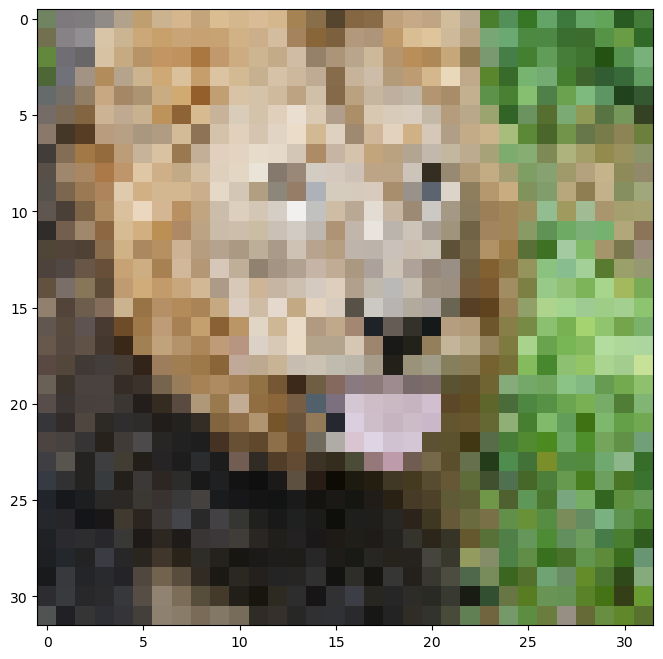

In [16]:
size = 32
train_data, test_data = get_image(size)

Some suggested hyperparameter choices:
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning reate: 1e-4


#### Low Resolution Reconstruction - SGD - None Mapping

First, let's try with SGD and no mapping.

  0%|          | 0/1000 [00:00<?, ?it/s]

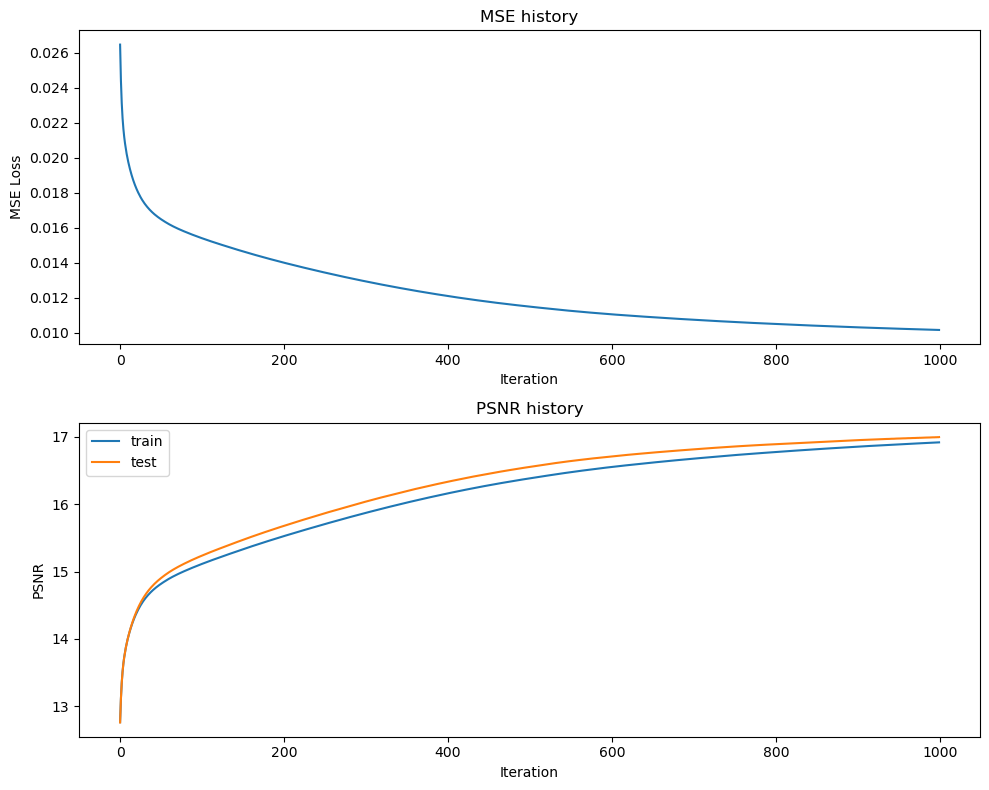

Final Test MSE 0.009989760692644201
Final Test psnr 16.994149196244436


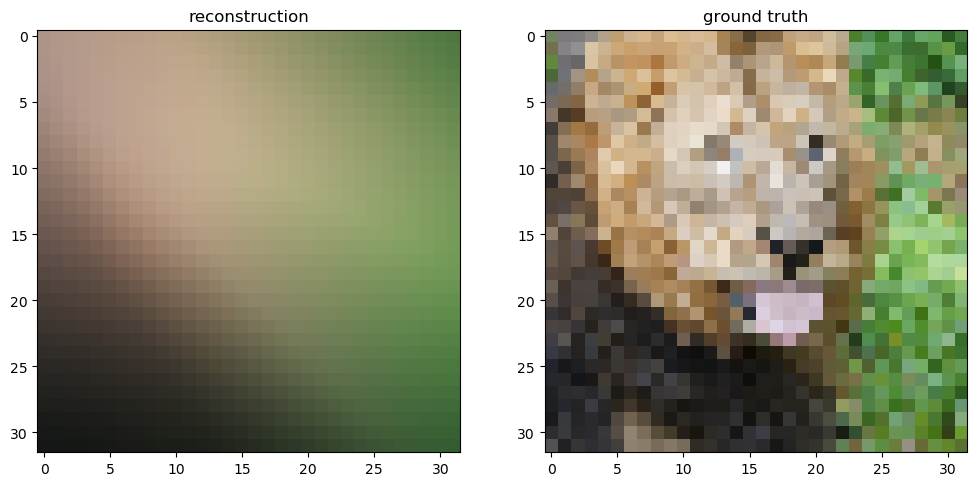

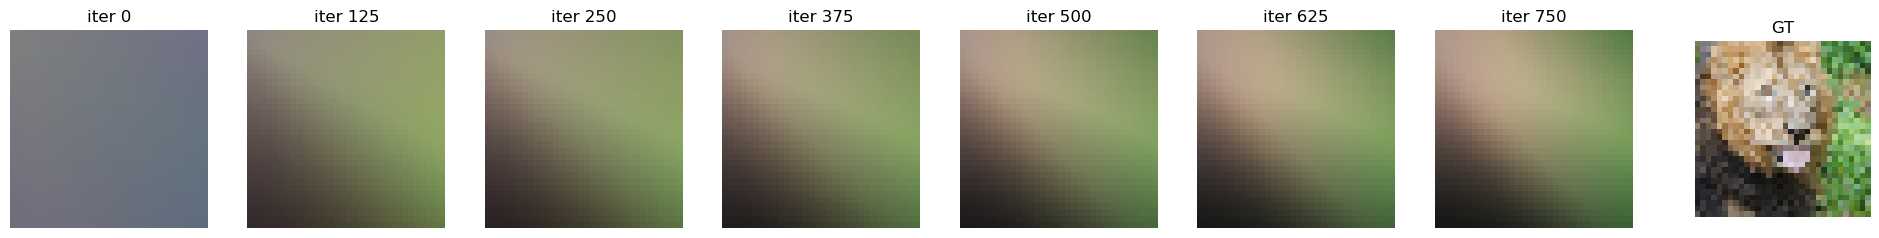

In [18]:
# get input features
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'none')

# run NN experiment on input features
num_layers = 4
hidden_size = 256
hidden_sizes = [256,256,256]
epochs = 1000
learning_rate = 0.5
opt = "SGD"
input_size = X_train.shape[1]
output_size = y_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                                          hidden_size, hidden_sizes, output_size, epochs,\
                                                                          learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

As we can see, the none mapping with SGD learns the general colors of the image, but you can't tell what the image is of, just that there is an orange/brown region on the left and a green region on the right of the image.

#### Low Resolution Reconstruction - Adam - None Mapping

Now, we'll try the Adam optimizer with no mapping.

  0%|          | 0/1000 [00:00<?, ?it/s]

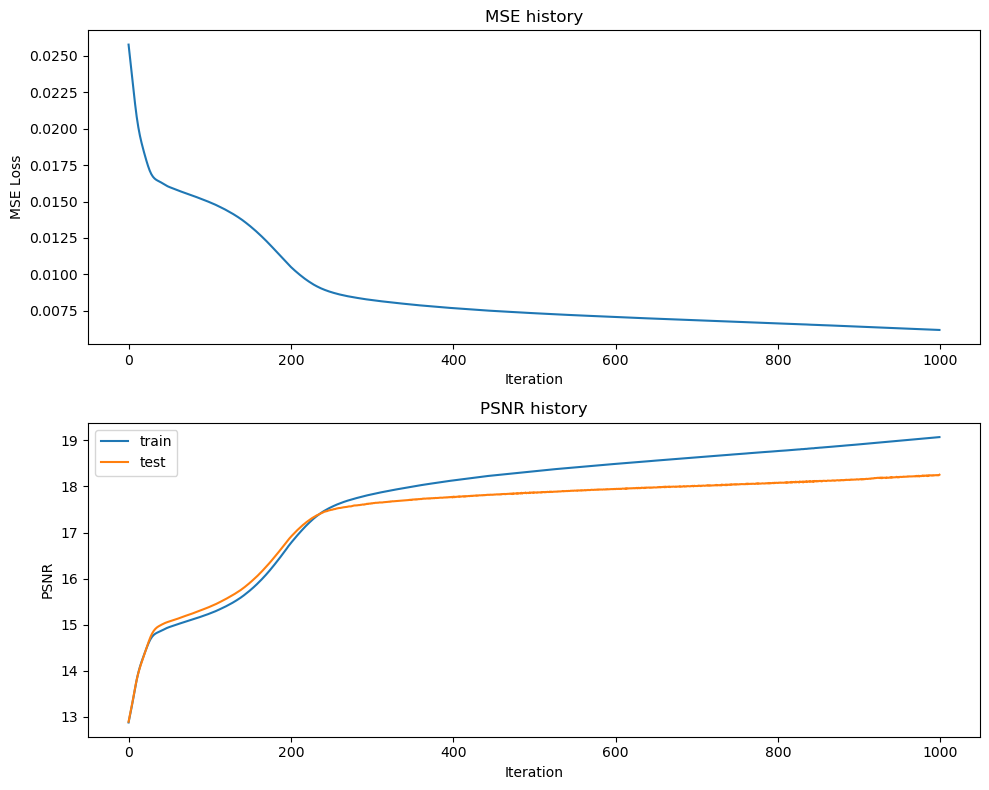

Final Test MSE 0.007498723994291215
Final Test psnr 18.239826355289182


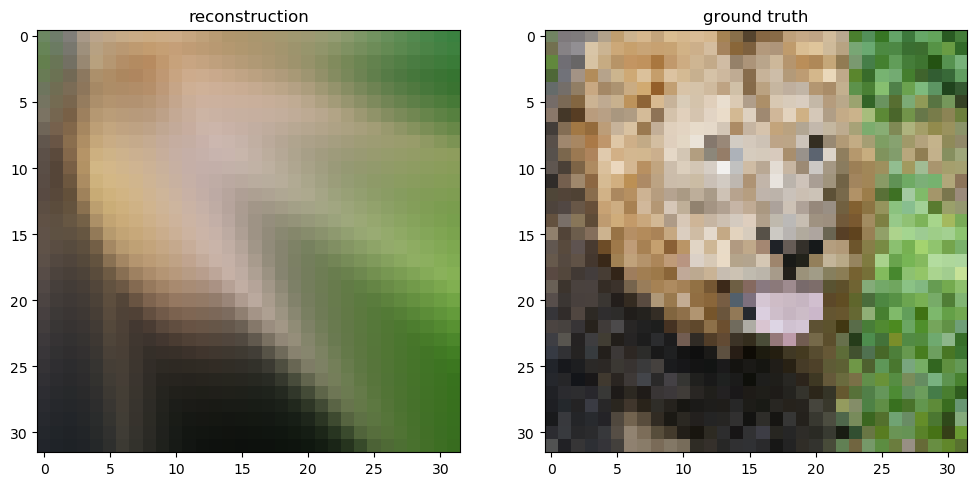

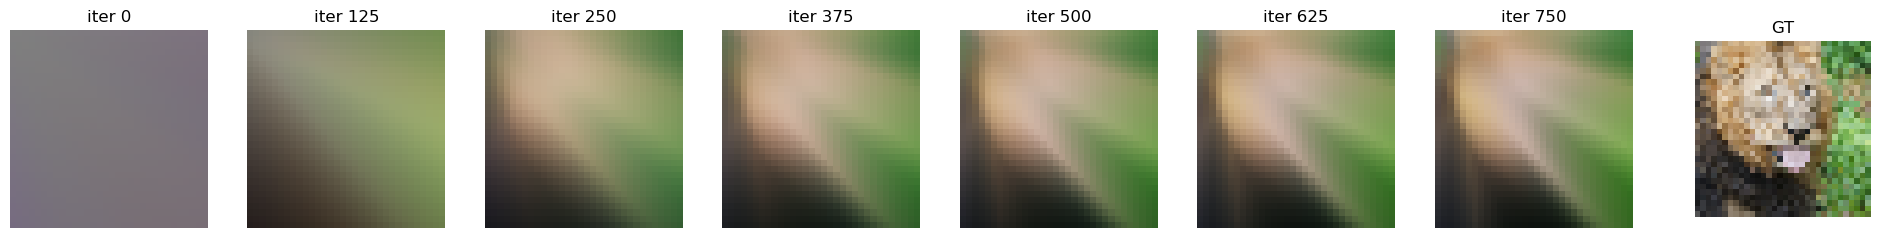

In [19]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'none')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
num_layers = 4
hidden_size = 256
hidden_sizes = [256,256,256]
epochs = 1000
learning_rate = 1e-4
opt = "Adam"
input_size = X_train.shape[1]
output_size = y_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                                          hidden_size, hidden_sizes, output_size, epochs,\
                                                                          learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

This looks better, but we still can't tell what the image is actually of. We also see these weird "rays" coming from the lions face. However, we still generally see the orange/brown left region and green right region of the image, but we can start to distinguish the colors of the lion's face and its mane.

We can also look at the MSE over time and PSNR over time and notice that with Adam, the MSE was lower and PSNR was higher, showing quantitatively better results than SGD.

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

Now, we'll try the Adam optimizer (since that seemed to work better both qualitatively and quantitatively) with all the mapping strategies.

In [20]:
def train_wrapper(mapping, size, opt):
    # TODO implement
    # makes it easy to run all your mapping experiments in a for loop
    # this will similar to what you did previously in the last two sections
    B_dict = get_B_dict()
    X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)
    
    num_layers = 4
    hidden_size = 256
    hidden_sizes = [256,256,256]
    epochs = 1000
    learning_rate = 1e-4
    if opt == "SGD":
        learning_rate = 0.5
        
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]

    net, train_psnrs, test_psnrs, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                                              hidden_size, hidden_sizes, output_size, epochs,\
                                                                              learning_rate, opt)
    
    return {
        'net': net, 
        'train_psnrs': train_psnrs, 
        'test_psnrs': test_psnrs,
        'train_loss': train_loss,
        'pred_imgs': predicted_images
    }



In [21]:
opt = "Adam"
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_10


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_100


  0%|          | 0/1000 [00:00<?, ?it/s]

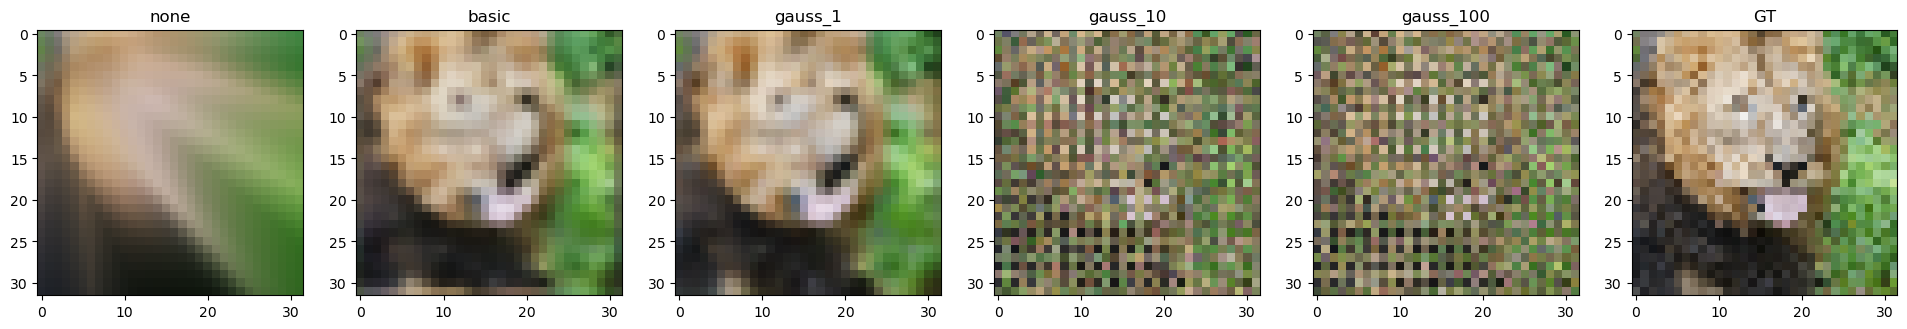

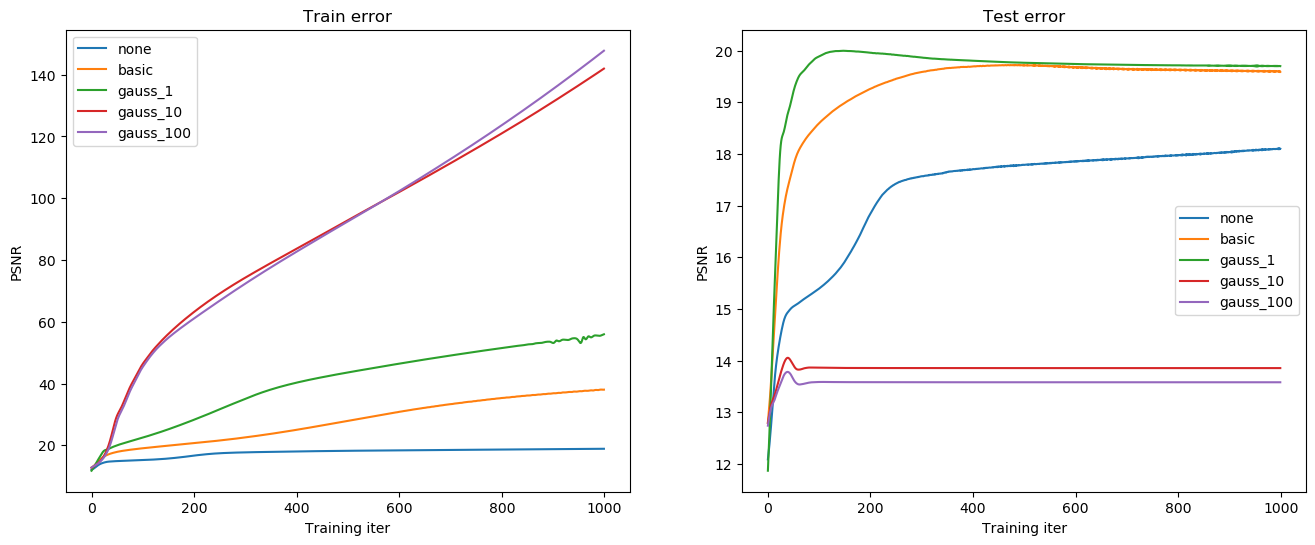

In [22]:
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

As we can see, with the low resolution reconstruction, the Gaussian Fourier feature mapping with $\sigma =1$ worked the best and we were able to learn our input image pretty well. Qualitatively, the basic and gauss_1 mappings look pretty similar, but looking at PSNR and MSE, we can see that the guass_1 mapping slightly outperformed the basic mapping.

# High Resolution Reconstruction

#### High Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

We're now going to repeat at a higher resolution, which will allow us to see how the mapping strategies perform better or worse at the two different input resolutions. 

C:\Users\amant\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


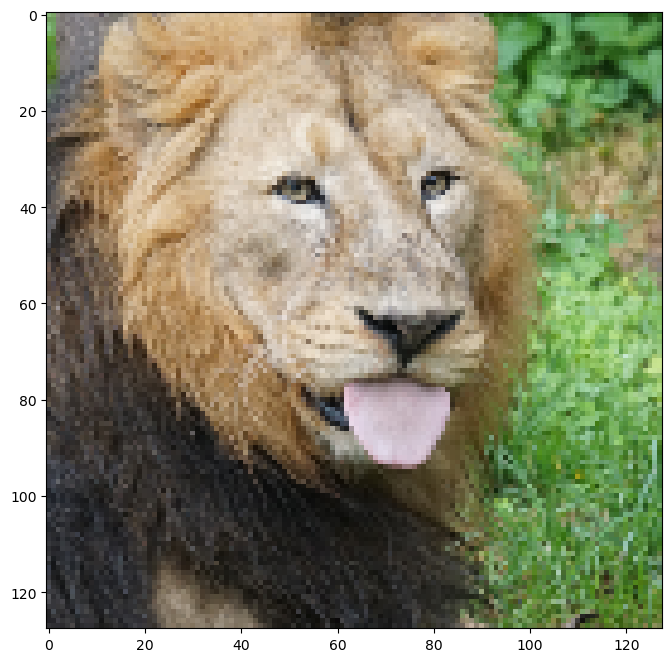

In [147]:
size = 128
train_data, test_data = get_image(size)

In [148]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size,opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_10


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_100


  0%|          | 0/1000 [00:00<?, ?it/s]

In [149]:
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, "gauss_10")

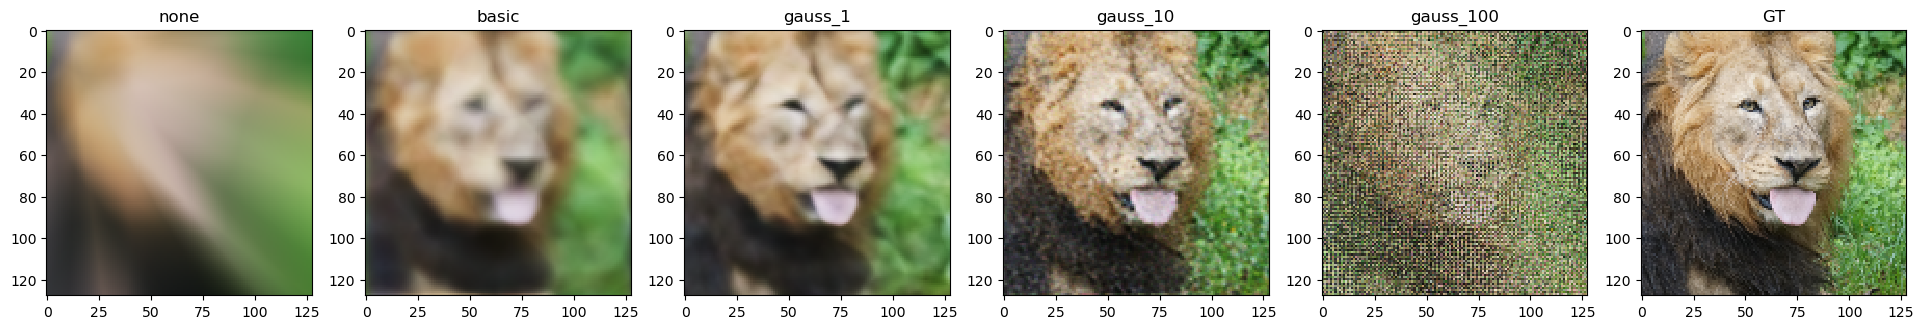

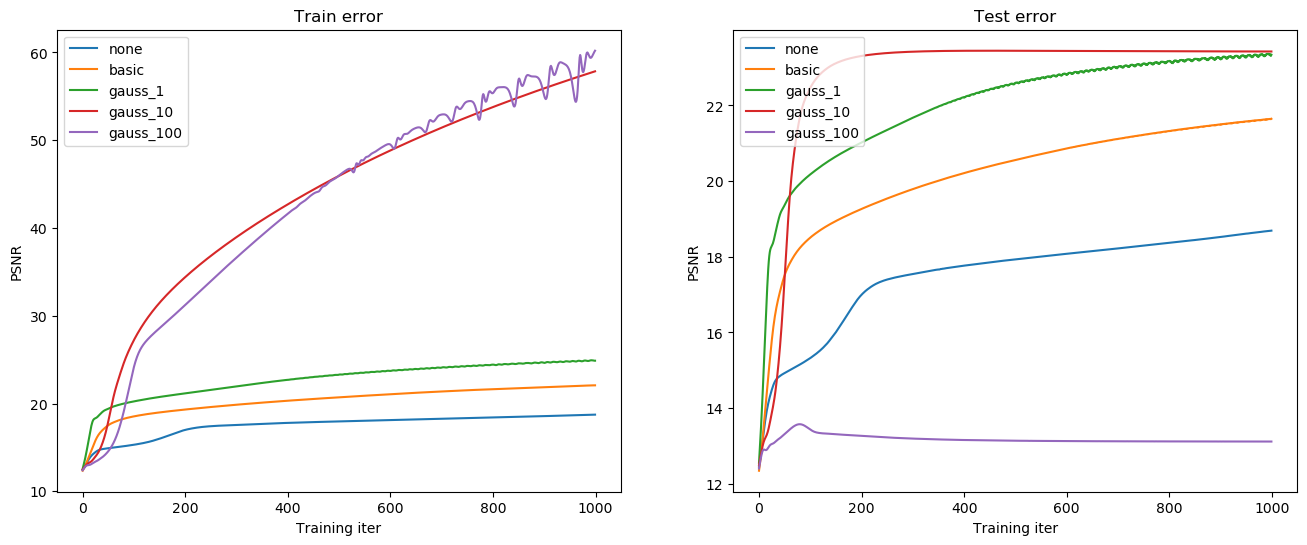

In [150]:
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

Here, we can see that the gauss_10 mapping actually works the best - this is because the higher standard deviation allows our mapping to capture higher frequencies, which are more present in higher resolution images. These high frequency components in images are the details in the picture, like the lion's hair. So, as we increase our resolution, the we'd want our mapping to have higher frequency components.

#### High Resolution Reconstruction - Image of your Choice

Now, we'll try this on an image of my friend's dog, Leni, and we'll see how the guass_10 mapping performs.

C:\Users\amant\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


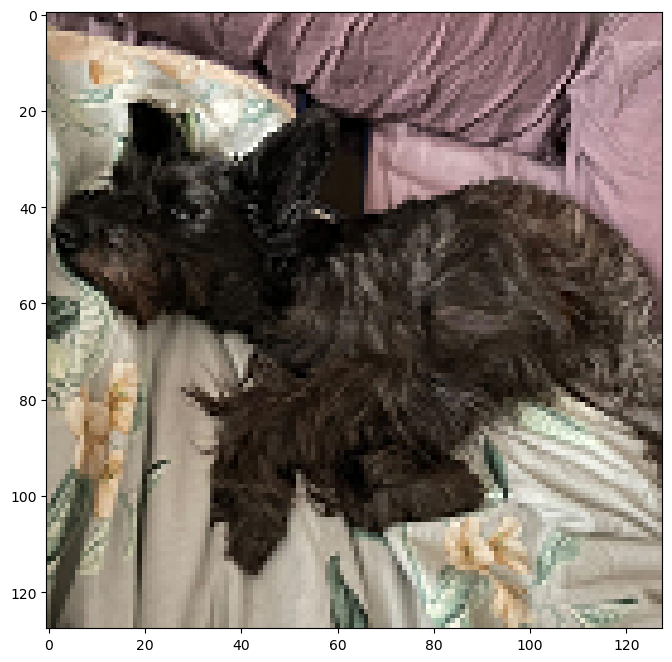

In [17]:
size = 128
# TODO pick an image and replace the url string
train_data, test_data = get_image(size, image_url="https://i.imgur.com/GLVlXOp.png")

  0%|          | 0/1000 [00:00<?, ?it/s]

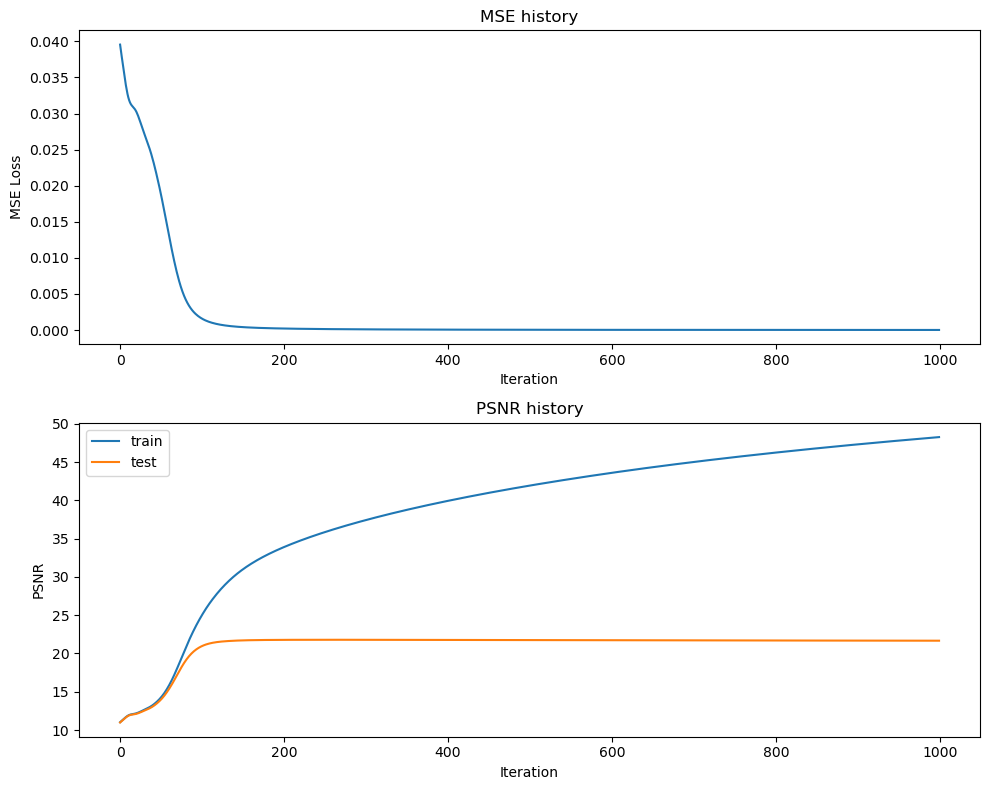

Final Test MSE 0.003405875808998782
Final Test psnr 21.66741196425779


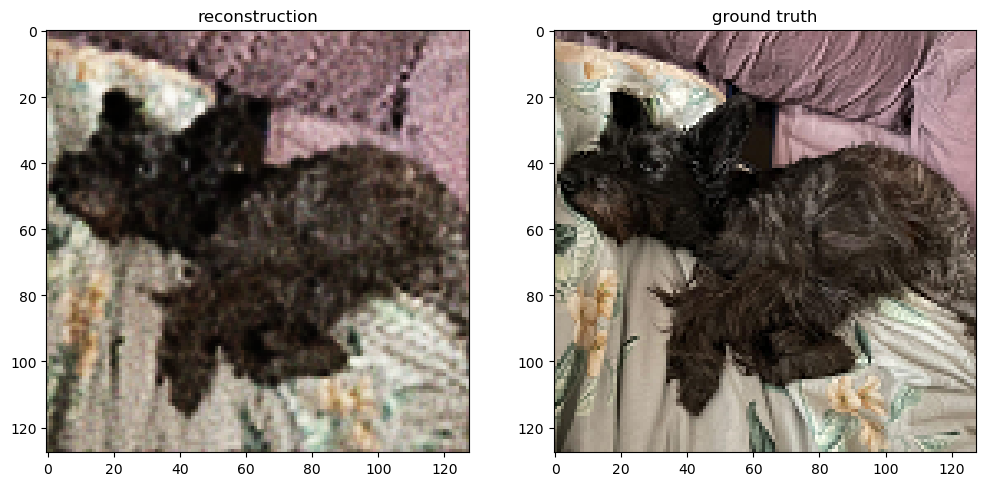

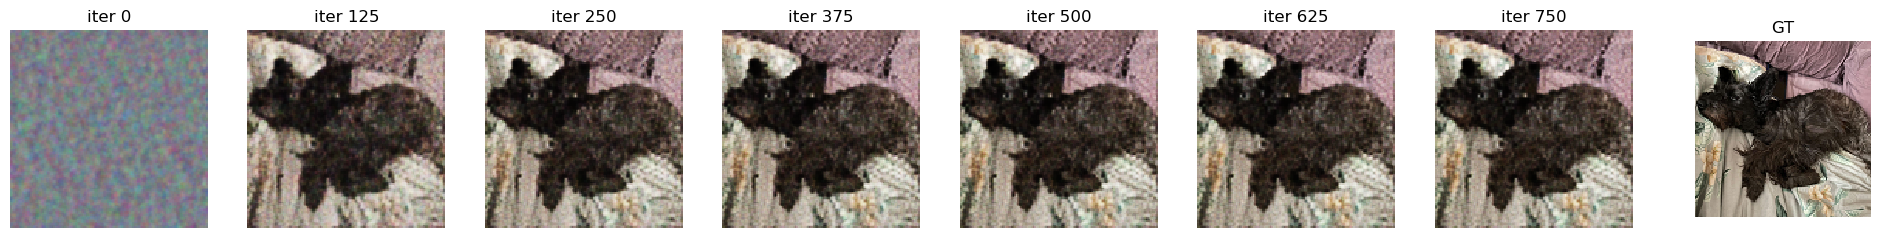

In [18]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'gauss_10')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
num_layers = 4
hidden_size = 256
hidden_sizes = [256,256,256]
epochs = 1000
learning_rate = 1e-4
opt = "Adam"
input_size = X_train.shape[1]
output_size = y_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                                          hidden_size, hidden_sizes, output_size, epochs,\
                                                                          learning_rate, opt)

plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

It works decently well - perhaps with some more training, we can get even better results, or by trying an even higher resolution.

### Trying even higher res

Here, we'll again try with an image of Leni but with a 512x512 image size. This will take a while to train.

C:\Users\amant\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


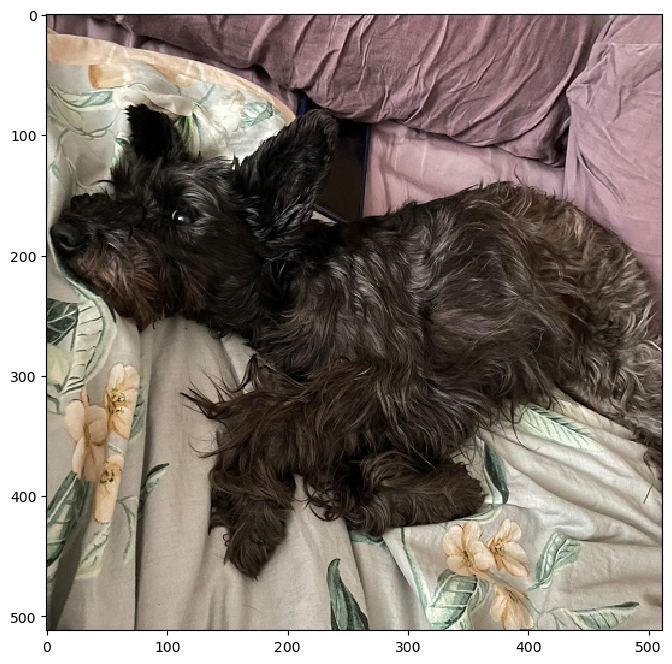

In [21]:
size = 512
# TODO pick an image and replace the url string
train_data, test_data = get_image(size, image_url="https://i.imgur.com/wWUyv2v.png")

  0%|          | 0/1000 [00:00<?, ?it/s]

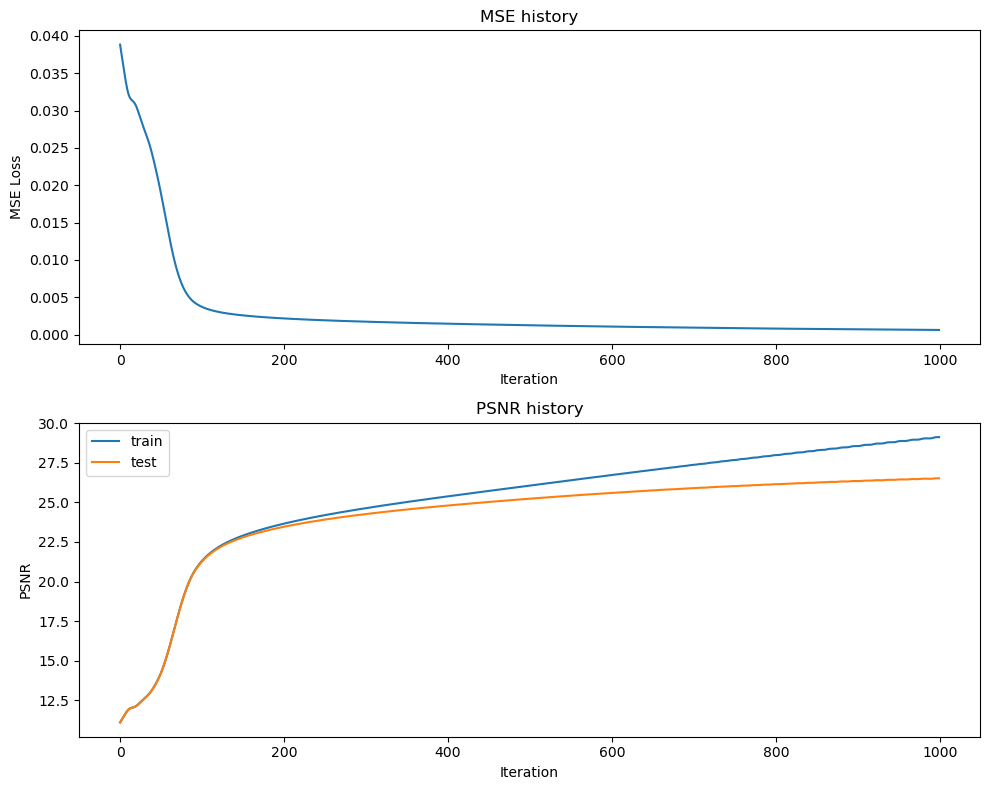

Final Test MSE 0.001115137175789455
Final Test psnr 26.516417100244443


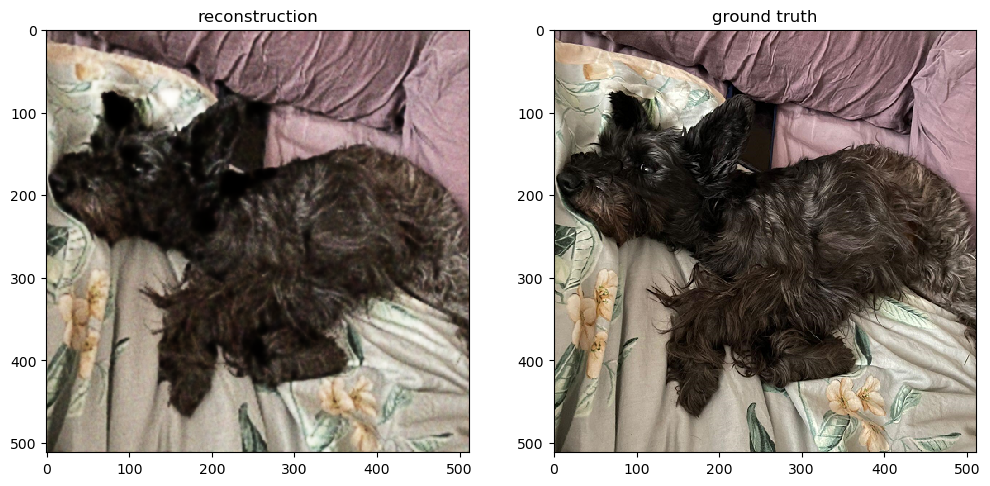

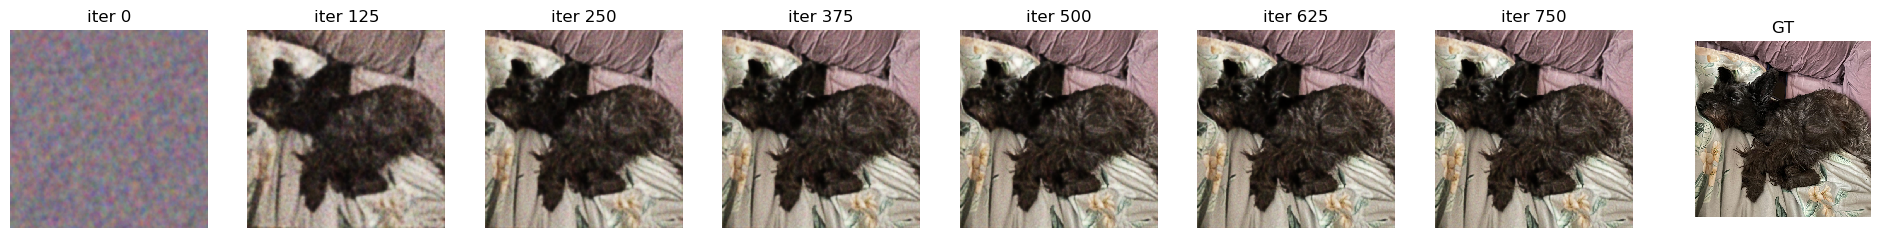

In [22]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'gauss_10')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
num_layers = 4
hidden_size = 256
hidden_sizes = [256,256,256]
epochs = 1000
learning_rate = 1e-4
opt = "Adam"
input_size = X_train.shape[1]
output_size = y_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                                                                          hidden_size, hidden_sizes, output_size, epochs,\
                                                                          learning_rate, opt)

plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

This reconstruction worked out really well. We again used the gauss_10 mapping, which was able to capture some, but not all, of the detail in the image. We can see that the reconstruction is a little blurry - perhaps using the gauss_100 mapping would yield even better results at these higher resolutions and with this extra detail in the image. 

# Reconstruction Process Video (Optional)
(For Fun!) Visualize the progress of training in a video 

In [ ]:
# requires installing this additional dependency
!pip install imageio-ffmpeg

In [ ]:
# single video example
size=512
create_and_visualize_video({"gauss": {"pred_imgs": predicted_images}}, size=512, filename="training_high_res_gauss.mp4")

In [ ]:
# multi video example
create_and_visualize_video(outputs, epochs=1000, size=32)